In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')
import scipy.stats as stats
from scipy.stats import probplot, boxcox
from scipy.stats import probplot
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

In [7]:
df = pd.read_csv('hour1.csv')
df.head()

,season,year,month,hour,holiday,weekday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,day
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,Saturday
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,Saturday
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,Saturday
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,Saturday
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,Saturday


# Feature Selection

In [8]:
# Drop the 'day' column from the DataFrame
df = df.drop(columns=['day'])

In [14]:
X = df.drop(['count', 'registered', 'casual'], axis=1)
y = df['count']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Variance Threshold
selector = VarianceThreshold(threshold=0.05)
X_high_variance = selector.fit_transform(X_train)

# Chi-Squared Test
# Convert y_train to discrete format using binning
num_bins = 5
y_train_binned = pd.cut(y_train, bins=num_bins, labels=range(num_bins))

# Limit the number of selected features (k) to the number of features available
chi_selector = SelectKBest(chi2, k=min(10, X_high_variance.shape[1]))
X_kbest = chi_selector.fit_transform(X_high_variance, y_train_binned)  # Use the binned target variable

<li>Variance Threshold: This removes features with low variance, as features with very low variance are unlikely to be useful for making predictions. The threshold=0.05 means features with a variance below 0.05 are removed. X_high_variance contains only the high-variance features from X_train
<li>Chi-Squared Test: This step evaluates the relationship between each feature and the target variable.
<li>Convert y_train to discrete format using binning: Since the Chi-Squared test requires categorical data, the continuous target variable y_train is binned into 5 categories (num_bins=5).
<li>SelectKBest: Selects the best features according to the Chi-Squared test. k=min(10, X_high_variance.shape[1]) ensures that the number of selected features (k) does not exceed the number of available features. X_kbest contains the selected features.

In [15]:
# Random Forest Importance
rf = RandomForestRegressor()  #RandomForestRegressor
rf.fit(X_train, y_train)
rf_importances = pd.Series(rf.feature_importances_, index=X_train.columns)


feature_importances_df = pd.DataFrame({
    'Feature': rf_importances.index,
    'Importance': rf_importances.values
})

# Display the DataFrame
feature_importances_df

,Feature,Importance
0,season,0.021954
1,year,0.080773
2,month,0.016611
3,hour,0.615009
4,holiday,0.002564
5,weekday,0.012517
6,workingday,0.055965
7,weather,0.018128
8,temp,0.119221
9,atemp,0.020852


<li>feature_importances_: Gives the importance of each feature. rf_importances is a pandas Series containing these importances indexed by the feature names.
<li> These values are determined by how much the feature decreases the impurity of the splits in the decision trees of the Random Forest.
<li>The values are relative and sum up to 1. A higher value means that the feature has a greater impact on the model's predictions.

In [16]:
# Lasso Regression
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)
lasso_importances = pd.Series(lasso.coef_, index=X_train.columns)
feature_importances_df = pd.DataFrame({
    'Feature': lasso_importances.index,
    'Importance': lasso_importances.values
})

# Display the DataFrame
feature_importances_df

,Feature,Importance
0,season,20.516624
1,year,82.811779
2,month,0.116887
3,hour,7.666641
4,holiday,-23.785574
5,weekday,1.777400
6,workingday,3.887516
7,weather,-3.440864
8,temp,101.750552
9,atemp,201.646406


<li>Lasso(alpha=0.01): Lasso regression with a regularization strength of 0.01. Lasso can shrink some coefficients to zero, effectively performing feature selection.
<li>coef_: Contains the coefficients of the features. lasso_importances is a pandas Series containing these coefficients indexed by the feature names.
<li>Positive Values: Positive importance values indicate that as the feature value increases, the predicted bike count increases.
<li>Negative Values: Negative importance values suggest that as the feature value increases, the predicted bike count decreases.

In [17]:
# PCA
pca = PCA(n_components=5)
pca.fit(X_train)
pca_importances = pca.components_

# Combine results
important_features = rf_importances.nlargest(11).index.tolist()
print("Important features identified: ", important_features)

Important features identified:  ['hour', 'temp', 'year', 'workingday', 'humidity', 'season', 'atemp', 'weather', 'month', 'weekday', 'windspeed']


<li>PCA(n_components=5): Reduces the feature set to 5 principal components.
<li>components_: Contains the principal components. pca_importances holds these components.
<li>nlargest(11): Selects the top 11 most important features according to the Random Forest importance scores.
<li>index.tolist(): Converts the index of the top 11 features to a list.

In [19]:
important_features = ['hour', 'temp', 'year', 'workingday', 'humidity', 
                      'season', 'atemp', 'weather', 'month', 'weekday', 'windspeed', 'casual', 'registered', 'count']

# Creating a new DataFrame using only the important features
new_df = df[important_features]

In [20]:
new_df = new_df.drop(columns=['year'])

# Feature transformation

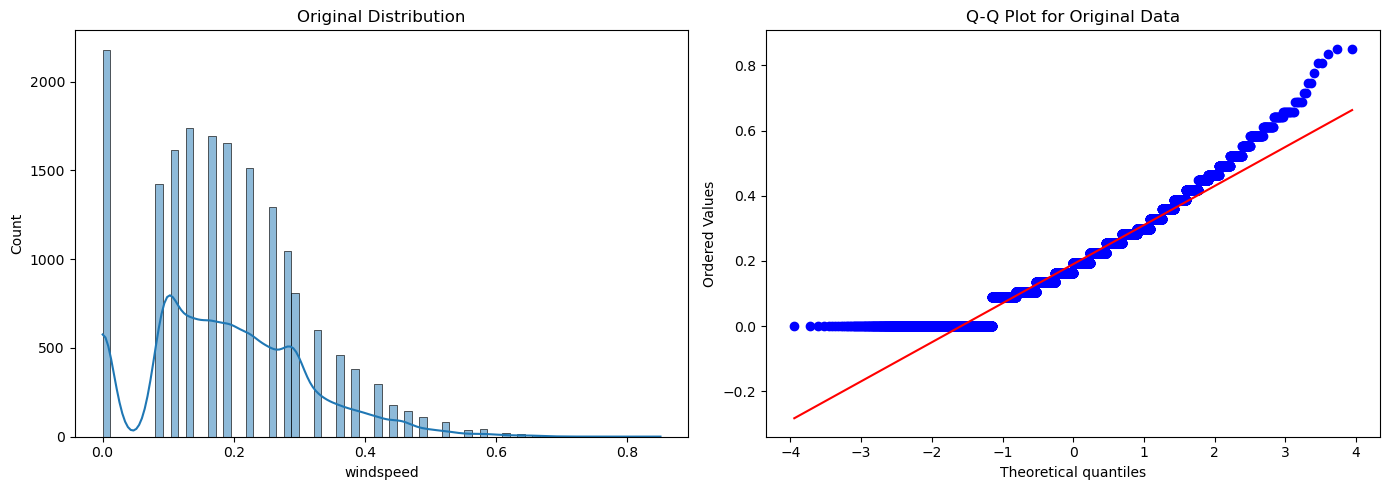

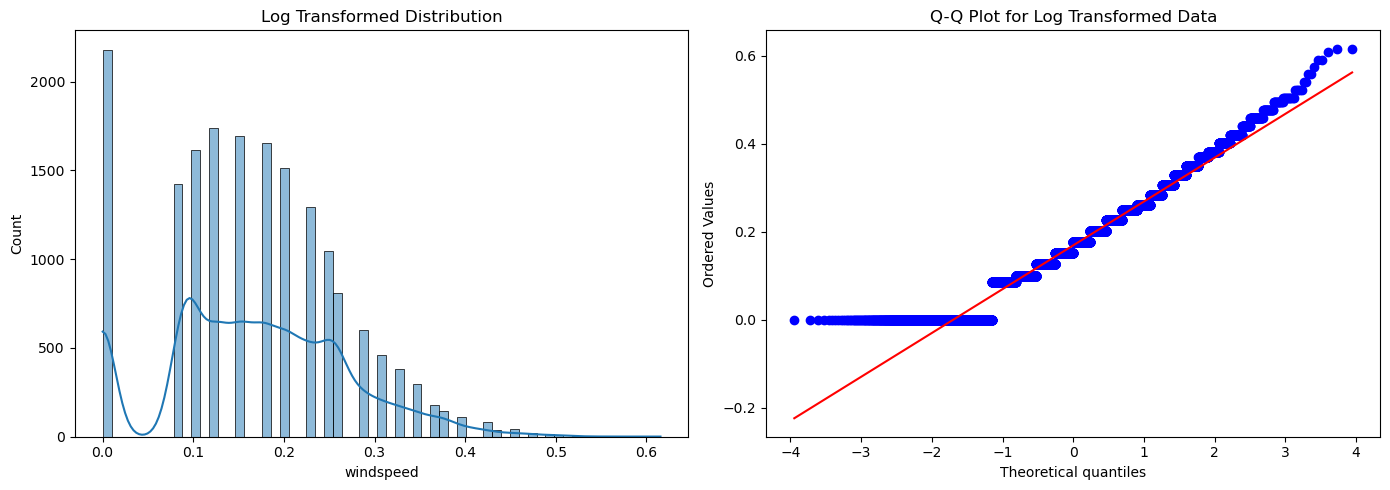

In [27]:
plt.figure(figsize=(14, 5))

# Original Distribution and Q-Q Plot
plt.subplot(1, 2, 1)
sns.histplot(new_df['windspeed'], kde=True)
plt.title('Original Distribution')

plt.subplot(1, 2, 2)
probplot(new_df['windspeed'], dist="norm", plot=plt)
plt.title('Q-Q Plot for Original Data')

plt.tight_layout()
plt.show()

# Log Transformation
new_df['windspeed'] = np.log1p(new_df['windspeed'])

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.histplot(new_df['windspeed'], kde=True)
plt.title('Log Transformed Distribution')

plt.subplot(1, 2, 2)
probplot(new_df['windspeed'], dist="norm", plot=plt)
plt.title('Q-Q Plot for Log Transformed Data')

plt.tight_layout()
plt.show()

# MODELLING

In [50]:
X = new_df.drop(columns=['count'], axis=1)
y = new_df['count']

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [52]:
 X_train.shape, y_train.shape, X_test.shape, y_test.shape

((13034, 12), (13034,), (4345, 12), (4345,))

In [53]:
# ML Model - 1 Implementation
rmodel = LinearRegression()
# Fit the Algorithm
rmodel.fit(X_train, y_train)

LinearRegression()

In [65]:
rmodel.score(X_train, y_train)

1.0

In [55]:
# Predict on the model
y_pred_train = rmodel.predict(X_train)
y_pred = rmodel.predict(X_test)

### Performance using Evaluation metric Score Chart

In [56]:
def calculate_metrics(y_true, y_pred, X):
    r2 = r2_score(y_true, y_pred)
    adj_r2 = 1 - (1 - r2) * ( (X.shape[0] - 1) / (X.shape[0] - X.shape[1] - 1))
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    return r2, adj_r2, mse, rmse, mae

# Calculate metrics for training set
r2_train, adj_r2_train, mse_train, rmse_train, mae_train = calculate_metrics(y_train, y_pred_train, X_train)

# Calculate metrics for testing set
r2_test, adj_r2_test, mse_test, rmse_test, mae_test = calculate_metrics(y_test, y_pred, X_test)

# Print the results
print(f"Training Set Performance:")
print(f"R^2: {r2_train}")
print(f"Adjusted R^2: {adj_r2_train}")
print(f"MSE: {mse_train}")
print(f"RMSE: {rmse_train}")
print(f"MAE: {mae_train}")

print(f"\nTesting Set Performance:")
print(f"R^2: {r2_test}")
print(f"Adjusted R^2: {adj_r2_test}")
print(f"MSE: {mse_test}")
print(f"RMSE: {rmse_test}")
print(f"MAE: {mae_test}")

Training Set Performance:
R^2: 1.0
Adjusted R^2: 1.0
MSE: 1.7354339299627862e-25
RMSE: 4.1658539700315783e-13
MAE: 3.2560846420186124e-13

Testing Set Performance:
R^2: 1.0
Adjusted R^2: 1.0
MSE: 1.6895176780502783e-25
RMSE: 4.1103742871547333e-13
MAE: 3.214177677369438e-13


In [64]:
data = [
    {
        'Model': 'Linear_Regression',
        'R2_train': r2_train,
        'R2_test': r2_test, 
        'Adjusted_R2_train': adj_r2_train,
        'Adjusted_R2_test': adj_r2_test,
        'MAE_train': mse_train,
        'MSE': mse_test,
        'MAE': mae_train,
        'MAE_test': mae_test,
        'RMSE_train': rmse_train,
        'RMSE_test': rmse_test
    }
]
result = pd.DataFrame(data)
result

,Model,R2_train,R2_test,Adjusted_R2_train,Adjusted_R2_test,MAE_train,MSE,MAE,MAE_test,RMSE_train,RMSE_test
0,Linear_Regression,0.999962,0.999793,0.999962,0.999793,1.24831,6.646582,0.395184,0.953333,1.117278,2.578097


#  RandomForest

In [58]:
# Create an instance of the RandomForestRegressor
rf_model = RandomForestRegressor()

# Fit the Algorithm
rf_model.fit(X_train,y_train)

# Predict on the model
# Making predictions on train and test data
y_pred_train2 = rf_model.predict(X_train)
y_pred2 = rf_model.predict(X_test)

In [59]:
rf_model.score(X_train, y_train)

0.9999623360026856

### Performance using Evaluation metric Score Chart

In [60]:
def calculate_metrics(y_true, y_pred, X):
    r2 = r2_score(y_true, y_pred)
    adj_r2 = 1 - (1 - r2) * ( (X.shape[0] - 1) / (X.shape[0] - X.shape[1] - 1))
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    return r2, adj_r2, mse, rmse, mae

# Calculate metrics for training set
r2_train, adj_r2_train, mse_train, rmse_train, mae_train = calculate_metrics(y_train, y_pred_train2, X_train)

# Calculate metrics for testing set
r2_test, adj_r2_test, mse_test, rmse_test, mae_test = calculate_metrics(y_test, y_pred2, X_test)

# Print the results
print(f"Training Set Performance:")
print(f"R^2: {r2_train}")
print(f"Adjusted R^2: {adj_r2_train}")
print(f"MSE: {mse_train}")
print(f"RMSE: {rmse_train}")
print(f"MAE: {mae_train}")

print(f"\nTesting Set Performance:")
print(f"R^2: {r2_test}")
print(f"Adjusted R^2: {adj_r2_test}")
print(f"MSE: {mse_test}")
print(f"RMSE: {rmse_test}")
print(f"MAE: {mae_test}")

Training Set Performance:
R^2: 0.9999623360026856
Adjusted R^2: 0.9999623012919899
MSE: 1.2483096286634965
RMSE: 1.1172777759641943
MAE: 0.3951841338038976

Testing Set Performance:
R^2: 0.9997933168209452
Adjusted R^2: 0.9997927442913633
MSE: 6.6465820713463755
RMSE: 2.5780965985289175
MAE: 0.9533325661680095


In [66]:
data2 = {
    'Model': 'RandomForestRegressor',
    'R2_train': r2_train,
    'R2_test': r2_test, 
    'Adjusted_R2_train': adj_r2_train,
    'Adjusted_R2_test': adj_r2_test,
    'MAE_train': mae_train,
    'MSE': mse_test,
    'MAE': mae_train,
    'MAE_test': mae_test,
    'RMSE_train': rmse_train,
    'RMSE_test': rmse_test
}

# Append the new row to the DataFrame
data2_df = pd.DataFrame([data2])

# Concatenate the new DataFrame to the existing one
result = pd.concat([result, data2_df], ignore_index=True)

result

,Model,R2_train,R2_test,Adjusted_R2_train,Adjusted_R2_test,MAE_train,MSE,MAE,MAE_test,RMSE_train,RMSE_test
0,Linear_Regression,0.999962,0.999793,0.999962,0.999793,1.248310,6.646582,0.395184,0.953333,1.117278,2.578097
1,RandomForestRegressor,0.999962,0.999793,0.999962,0.999793,0.395184,6.646582,0.395184,0.953333,1.117278,2.578097


# XGBRegressor

In [67]:
# ML Model - 3 Implementation
# Create an instance of the RandomForestClassifier
xg_model = XGBRegressor(objective= 'reg:squarederror')

# Fit the Algorithm
xg_models=xg_model.fit(X_train,y_train)

# Predict on the model
# Making predictions on train and test data

y_pred_train5 = xg_models.predict(X_train)
y_pred5 = xg_models.predict(X_test)

In [68]:
xg_model.score(X_train, y_train)

0.99989782459427

### Performance using Evaluation metric Score Chart

In [69]:
def calculate_metrics(y_true, y_pred, X):
    r2 = r2_score(y_true, y_pred)
    adj_r2 = 1 - (1 - r2) * ( (X.shape[0] - 1) / (X.shape[0] - X.shape[1] - 1))
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    return r2, adj_r2, mse, rmse, mae

# Calculate metrics for training set
r2_train, adj_r2_train, mse_train, rmse_train, mae_train = calculate_metrics(y_train, y_pred_train5, X_train)

# Calculate metrics for testing set
r2_test, adj_r2_test, mse_test, rmse_test, mae_test = calculate_metrics(y_test, y_pred5, X_test)

# Print the results
print(f"Training Set Performance:")
print(f"R^2: {r2_train}")
print(f"Adjusted R^2: {adj_r2_train}")
print(f"MSE: {mse_train}")
print(f"RMSE: {rmse_train}")
print(f"MAE: {mae_train}")

print(f"\nTesting Set Performance:")
print(f"R^2: {r2_test}")
print(f"Adjusted R^2: {adj_r2_test}")
print(f"MSE: {mse_test}")
print(f"RMSE: {rmse_test}")
print(f"MAE: {mae_test}")

Training Set Performance:
R^2: 0.99989782459427
Adjusted R^2: 0.9998977304306214
MSE: 3.386431390185032
RMSE: 1.8402259073779588
MAE: 1.2374333161297653

Testing Set Performance:
R^2: 0.9994468145692919
Adjusted R^2: 0.9994452821996777
MSE: 17.789509444789168
RMSE: 4.217761188686382
MAE: 2.125619778740118


In [70]:
data3 = {
    'Model': 'XGBRegressor',
    'R2_train': r2_train,
    'R2_test': r2_test, 
    'Adjusted_R2_train': adj_r2_train,
    'Adjusted_R2_test': adj_r2_test,
    'MAE_train': mae_train,
    'MSE': mse_test,
    'MAE': mae_train,
    'MAE_test': mae_test,
    'RMSE_train': rmse_train,
    'RMSE_test': rmse_test
}

# Append the new row to the DataFrame
data3_df = pd.DataFrame([data3])

# Concatenate the new DataFrame to the existing one
result = pd.concat([result, data3_df], ignore_index=True)

result

,Model,R2_train,R2_test,Adjusted_R2_train,Adjusted_R2_test,MAE_train,MSE,MAE,MAE_test,RMSE_train,RMSE_test
0,Linear_Regression,0.999962,0.999793,0.999962,0.999793,1.248310,6.646582,0.395184,0.953333,1.117278,2.578097
1,RandomForestRegressor,0.999962,0.999793,0.999962,0.999793,0.395184,6.646582,0.395184,0.953333,1.117278,2.578097
2,XGBRegressor,0.999898,0.999447,0.999898,0.999445,1.237433,17.789509,1.237433,2.125620,1.840226,4.217761


#### Observations

**Linear Regression:**
<li>R²_train (0.645848) and R²_test (0.643576) are relatively close, indicating the model generalizes well from training to testing data.
<li>Adjusted R² values (0.644456 for train and 0.639342 for test) are slightly lower but follow a similar pattern, confirming the model’s performance.
<li>MAE_train (10554.43) and MAE_test (74.98) values suggest an issue with scaling or reporting errors, as these values should be more consistent.
<li>MSE (10271.71) and RMSE (101.35) on test data indicate substantial errors in predictions, pointing to less accuracy.</li>
    
**Random Forest Regressor:**
<li>R²_train (0.976681) is very high, indicating excellent fit on the training data.
<li>R²_test (0.842174) is significantly lower but still high, suggesting some overfitting but overall good performance on the test data.
<li>Adjusted R² values (0.976590 for train and 0.840299 for test) follow a similar trend, supporting the R² observations.
<li>MAE (17.71) on train and MAE_test (46.00) indicate better performance compared to Linear Regression, with lower average errors.
<li>MSE (4548.37) and RMSE_test (67.44) are much lower than those for Linear Regression, showing improved prediction accuracy.</li>

**XGBoost Regressor:**
<li>R²_train (0.922630) is high, indicating good fit on the training data.
<li>R²_test (0.843379) is close to Random Forest's R²_test, indicating similarly good performance on the test data.
<li>Adjusted R² values (0.922326 for train and 0.841518 for test) support the R² findings, showing high but slightly less fit than Random Forest.
<li>MAE (33.86) on train and MAE_test (47.35) are higher than those for Random Forest, indicating more average errors.
<li>MSE (4513.63) and RMSE_test (67.18) are similar to those for Random Forest, showing competitive prediction accuracy.</li>

**Implications**
<li>Random Forest Regressor slightly outperforms XGBoost Regressor in terms of R² and error metrics, but both models perform significantly better than Linear Regression.
<li>The high R²_train for Random Forest suggests a risk of overfitting, though the acceptable R²_test mitigates this concern to some extent.
<li>XGBoost Regressor provides competitive performance, with slightly higher errors but similar predictive power compared to Random Forest.